In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import requests

# Blood Cells Feature Extraction


## Abstract
The count of blood cells is a widely used to detect abnormalities and to diagnose different diseases. Given an image with a blood smear we try to extract the separate cells and find any distinctive properties of them based on their contours. However, the current process is too limited as it does not give correct results for cells that are very tightly connected or at the border of the image. It is necessary that further investigation and improvement to be made.

## Introduction

The main task of this notebook is trying to extract blood cells from a dataset with blood smears including various types of cells with different types, coloring, shapes, etc. The main dataset that we will use is https://mahmudulalam.github.io/Complete-Blood-Cell-Count-Dataset/. It contains 360 blood smear images. Let's try to segment and detect the blood cells using image processing techniques using OpenCV library.

### Short description of blood smears

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0208521617304072-gr1.jpg">

Major types of blood cells include:

| Major Cell Type| Main Function | Diameter | Specific characteristics|
| --- | --- | --- | --- |
| Red blood cells (erythrocytes) | carry oxygen | 6 - 8 μm. | oval biconcave disks (i.e. disc-shaped with a pale-staining central area) without a cell nucleus and most organelles|
| White blood cells (leukocytes) | immune system | 12 - 17 µm | have a clear nucleus; different types: neutrophils, eosinophils, basophils, lymphocytes, and monocytes |
| Platelets (thrombocytes) | initiate a blood clot | 2 – 3 µm in greatest diameter | very small, no nucleus |

Whole blood contains red cells, white cells, and platelets (45% of volume) suspended in blood plasma (55% of volume).


Now, let's try to look at a sample image from the dataset. But first, let's define a few help functions for reading an image from an url and plotting an image.

In [3]:
def read_image_by_url(url):
    """
    read an image by a given url containing an image
    """
    response = requests.get(url, stream = True).raw
    image = np.asarray(bytearray(response.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_image(
    image, 
    title, 
    colour_map = "gray",
    show_figure = True,
    plot_axis = None):
    """
    shows an OPENCV image in BGR format with a given title
    @colour_map - it can be "gray" or "color"
    """
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
        
    if colour_map == "color":
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
    elif colour_map == "gray":
        ax.imshow(image, cmap = colour_map)
    else:
        raise ValueError("The colour map must be either \"color\" or \"gray\"")
        
    ax.set_title(title)
    ax.axis("off")
    if show_figure:
        plt.show()    

In [4]:
URL = "https://raw.githubusercontent.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset/master/Testing/Images/"

Let's look at a few sample images:

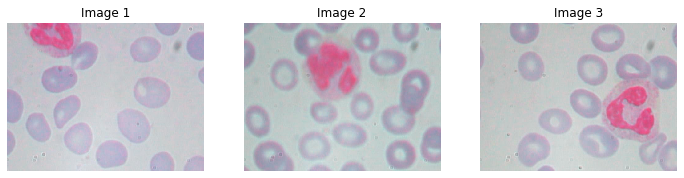

In [5]:
image1 = read_image_by_url(URL + "BloodImage_00388.jpg")
image2 = read_image_by_url(URL + "BloodImage_00398.jpg")
image3 = read_image_by_url(URL + "BloodImage_00384.jpg")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
plot_image(image1, "Image 1", plot_axis = ax1, show_figure = False)
plot_image(image2, "Image 2", plot_axis = ax2, show_figure = False)
plot_image(image3, "Image 3", plot_axis = ax3, show_figure = False)
plt.show()

## Segmentation

### Preprocessing
Usually the input images are not always clear enough and they need some initial preprocessing in order to improve contrast, eliminate noise if possible and generally improve the quality of the image. Also, it is a good idea to have some "standard" initial conditions for all processed images in order to produce more accurate results with the further processing.

Here are the two main preprocessing techniques we will try:
- Histogram Equalization
- Filtering

In [6]:
def plot_image_colors_histogram(
    image,
    show_figure = True, 
    plot_axis = None):
    
    ax = plot_axis
    if plot_axis == None:
        _, ax = plt.subplots()
    
    ax.hist(image.flatten(), 256, [0, 256], color = 'g')
    ax.set_xlim([0, 256])
    ax.set_title("Colors distribution")   
    ax.set_xlabel("Color intensity levels [0, 255]")
    ax.set_ylabel("Number of pixels")
    
    if show_figure:
        plt.show()

#### Histogram Equalization
In the provided dataset, images have more specific range of values i.e. the images are a little bit more brighter and most of their pixels have high values. We will try to have values from the whole grayscale spectrum. The idea is to improve the contrast of the image.
Let's take a look:

In [7]:
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

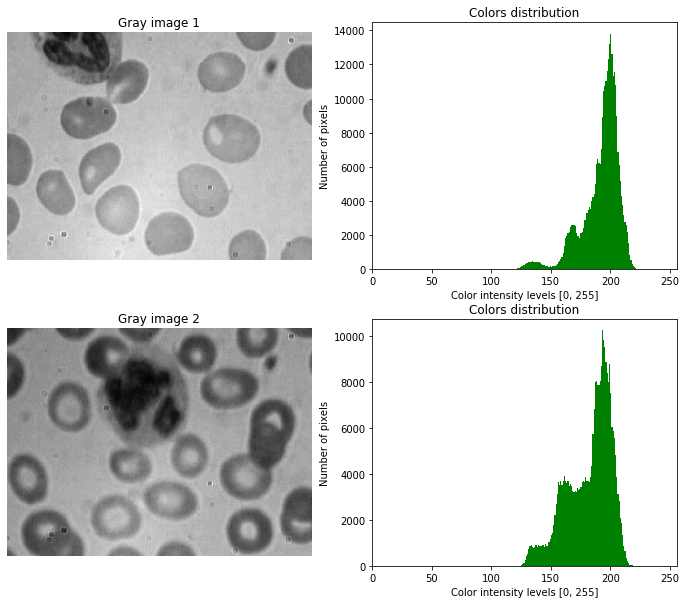

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
plot_image(gray_image1, "Gray image 1", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(gray_image1, plot_axis = ax2, show_figure = False)
plot_image(gray_image2, "Gray image 2", plot_axis = ax3, show_figure = False)
plot_image_colors_histogram(gray_image2, plot_axis = ax4, show_figure = False)
plt.show()

We can consider the discrete grayscale image {x} as a matrix of integer pixel intensities ranging from 0 to L-1 (usually 256).

1.) Find the probability of each pixel intensity

$$ p_{x}(i) = p_{x}(x=j) = \frac{n_{i}}{n}, i = 0, 1, ..., L-1 $$
 * $ n_{i} $ - the number of the pixels with intensity i
 * $ n $ - the total number of pixels in the image

2.) Find the cummulatitive probability - the probability that the pixel intensity is less than or equal to a given value
$$ cdf_{x}(i)=\sum_{j=0}^{i}p_{x}(x=j)$$

3.) Contrast stretching to the new range of value 

 $$ x_{i}=(x_{i}-{\text{Min}}){\frac {{\text{newMax}}-{\text{newMin}}}{{\text{Max}}-{\text{Min}}}}+{\text{newMin}} $$

4.) Remapping the image to the new values based on the lookup table with the new values

In [9]:
def normalize(image, new_min, new_max):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) * (new_max - new_min)/(image_max - image_min) + new_min
    
def equalize_histogram(image):
    hist, bins = np.histogram(image1.flatten(), 256, [0,256])
    
    # [sum(h[:i+1]) for i in range(len(h))]
    cdf = np.cumsum(hist)
    
    # normalize cdf values between [0, 255]
    cdf_mask = np.ma.masked_equal(cdf, 0) # ignore zeroes
    cdf_mask = normalize(cdf_mask, 0, 255)
    normalized_cdf = np.ma.filled(cdf_mask, 0).astype('uint8')
    
    return normalized_cdf[image]

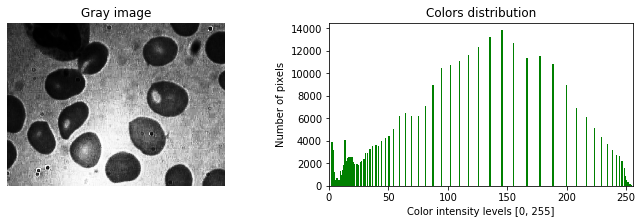

In [10]:
enhanced_image = equalize_histogram(gray_image1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
plot_image(enhanced_image, "Gray image", plot_axis = ax1, show_figure = False)
plot_image_colors_histogram(enhanced_image, plot_axis = ax2, show_figure = False)
plt.show()

Fortunately, we can use the OpenCV function: cv2.equalizeHist(img)

>Note:
>Histogram equalization is good when histogram of the image is confined to a particular region. But it is not always the case.

So it is better not to consider the global contrast of the image but try to process smaller blocks and histogram equalized them. The process is called adaptive histogram equalization - Contrast Limiting Adaptive Histogram Equalization (CLAHE). It is again implemented in OpenCV.

1.) The image is divided into small blocks or “tiles” (tileSize is 8x8 by default) and are histogram equalized.

2.) Contrast limiting is applied to avoid amplifying the noise in the small blocks. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 

3.) Bilinear interpolation is applied after the equalization, to remove artifacts in tile borders.

We apply CLAHE to the RGB image (OpenCV BGR). In order to do that, we use LAB color space on the L (lightness/intensity value) preserving the color components.

> LAB:
> * L – Lightness (Intensity)
> * a – color component ranging from Green to Magenta
> * b – color component ranging from Blue to Yellow

In [11]:
def increase_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    l2 = clahe.apply(l)

    lab = cv2.merge((l2,a,b))
    img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR) 
    
    return img2

### Edges and Gaussian Filter

Our main aim is to find the edges between cells in order to extract them. In images edges occur at boundaries between regions of different color, intensity or texture. A widely used approach is to define an edge as a location of rapid intensity variation.
A mathematical way to define the slope and direction of a surface is through its gradient:

$$ J(x) = ∇I(x)=( \frac{∂I}{∂x}, \frac{∂I}{∂y})(x)$$

* the magnitude is an indication of the slope or strength of the variation
$$ ||∇f(x)|| = \sqrt {(\frac{∂f}{dx})^{2}+(\frac{∂f}{∂y})^{2}} $$ 
* the orientation points in the direction of the most rapid increase in intensity (the steepest ascent)
$$ \theta = {tan{^{-1}}} \left[{\frac{∂f}{∂y}}/{\frac{∂f}{∂x}}\right] $$

<img src="https://image.slidesharecdn.com/finalminorprojectppt-140422115839-phpapp02/95/fuzzy-logic-based-edge-detection-16-638.jpg?cb=1398168182">

Unfortunately, taking image derivatives increases high frequencies and hence amplifies
noise, since the proportion of noise to signal is larger at high frequencies. So it is a good idea to smooth the image with a low-pass filter prior to computing the gradient. The Gaussian filter is useful here as it is a circularly symmetric smoothing filter and is independent of orientation.

The Gaussian Filter is used to blur an image in order to remove noise. It involves determining the weighted average of the surrounding pixels. The kernel represents a discrete approximation of a Gaussian distribution. While the Gaussian filter blurs the edges of an image (like the mean filter) it does a better job of preserving edges than a similarly sized mean filter.

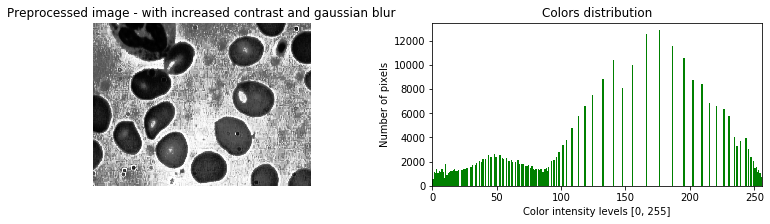

In [12]:
image1_with_increased_contrast = increase_contrast(image1)
gray_image1 = cv2.cvtColor(image1_with_increased_contrast, cv2.COLOR_RGB2GRAY)
equalized_image1 = cv2.equalizeHist(gray_image1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3))
plot_image(equalized_image1, "Preprocessed image - with increased contrast and gaussian blur",
           show_figure = False, plot_axis = ax1)
plot_image_colors_histogram(equalized_image1, show_figure = False, plot_axis = ax2)
plt.show()

### Image Segmentation

Now, as we have done some prepocessing, we can try to divide the image into segments in order to find the objects of interest - the separate cells.

#### Otsu thresholding
Edge Detection makes used of discontinuous local features of an image to detect edges and hence define a boundary of the object. It is good for images having better contrast between objects.

Otsu thresholding works better when there are two distinct image values (bimodal image), where the histogram would only consist of two peaks. In our test image to some extent we can see a clear threshold between the foreground and background in the histogram above. Otsu's method determines an optimal global threshold value from the image histogram.

Otsu's algorithm tries to find a threshold value (t) which minimizes the weighted within-class variance given by the relation:
Weights $\omega _{b}$ and $\omega_{f}$ are the probabilities of the two classes separated by a threshold $t$,and $\sigma_{b}^{2}$ and $\sigma_{f}^{2}$ are variances of these two classes.
* background: $ \omega_{b} = \sum_{i=0}^{t-1}p(i) $
* foreground: $ \omega_{f} = \sum_{i=t}^{L-1}p(i) $ 

The algorithm searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes:
$$ \sigma_{w}^{2}(t) = \omega_{b}(t)\sigma_{b}^{2}(t) + \omega_{f}(t)\sigma_{f}^{2}(t) $$

However, it is computationally even easier to compute intra-class variance and minimizing the intra-class variance is equivalent to maximizing inter-class variance:

$$ \sigma_{b}^{2}(t) = \sigma^{2}-\sigma_{w}^{2}(t) = \omega_{b}(\mu_{b}-\mu)^{2}+\omega_{f}(\mu_{f}-\mu)^{2} = \omega_{b} \omega_{f} (\mu_{b}-\mu_{f})^{2} $$

(taking into account $ \omega_{b} + \omega_{f} = 1$)
* $ \mu_{b}(t)=\frac{\sum_{i=0}^{t-1}ip(i)}{\omega_{b}} $
* $ \mu_{f}(t)=\frac{\sum_{i=t}^{L-1}ip(i)}{\omega_{f}} $
* $ \mu=\sum_{i=0}^{L-1}ip(i) $


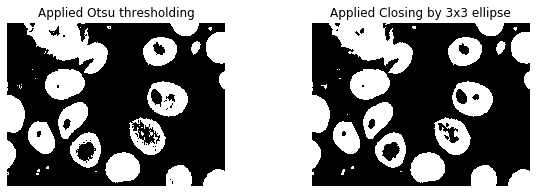

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 3))

otsu_threshold1, otsu_image1 = cv2.threshold(gray_image1, 0, 255,
                                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plot_image(otsu_image1, "Applied Otsu thresholding", plot_axis = ax1, show_figure = False)

structuring_element1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
image1_closed_otsu = cv2.morphologyEx(otsu_image1, cv2.MORPH_CLOSE, 
                                         structuring_element1, iterations = 3)
plot_image(image1_closed_otsu, "Applied Closing by 3x3 ellipse", plot_axis = ax2, show_figure = False)
plt.show()    

#### Canny Edge Detection

The Process of Canny edge detection algorithm consists of a few steps:

- Apply Gaussian filter to smooth the image in order to remove the noise
- Find the intensity gradients of the image
- Apply non-maximum suppression or edge thinning - find the locations with the sharpest change of intensity value i.e. looking to the pixels around a given one in different directions and keeps it if it has the largest edge strength (gradient magnitude) 
- Apply double threshold to determine potential edges - threshold values: minVal and maxVal
   - edges with intensity gradient above maxVal - sure edges
   - edges below minVal - non-edges; discarded
   - edges between minVal and maxVal - sure-edges if they are connected to “sure-edge” pixels
 

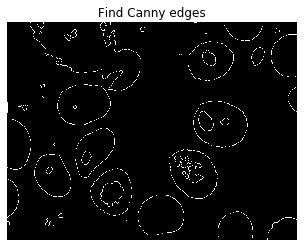

In [14]:
  canny_image1 = cv2.Canny(image1_closed_otsu, otsu_threshold1, 0.5*otsu_threshold1)
  plot_image(canny_image1, "Find Canny edges")  

#### Contours

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity.

OpenCV implements Satoshi Suzuki algorithm (1985). It defines the hierarchical relationships among the borders. This algorithm also differentiates between the outer boundary or the hole boundary. Let’s say $I_{ij} $ denotes the value of the pixel at location $(i,j)$. The uppermost row, the lowermost row, the leftmost column, and the rightmost column of a picture compose its frame. We assign a unique number to every new border found and we denote it by NBD. We assume the NBD of the frame as 1. Rest borders are numbered sequentially. We save the information of the parent of any border in LNBD or last NBD.


In [15]:
class Contour:
    
    def __init__(self, contour, image):
        self.points = contour 
        
        area = cv2.contourArea(contour)
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # enclosing circle
        enclosing_circle_center_x, enclosing_circle_center_y = (int(x), int(y))
        enclosing_circle_diameter = 2 * int(radius)
        
        # Hu moments
        [h1, h2, h3, h4, h5, h6, h7] = cv2.HuMoments(cv2.moments(contour)).flatten()
        
        self.data = {
            "area": area,
            "enclosing_circle_center_x": enclosing_circle_center_x,
            "enclosing_circle_center_y": enclosing_circle_center_y,
            "enclosing_circle_diameter": enclosing_circle_diameter,
            "h1": h1,
            "h2": h2,
            "h3": h3,
            "h4": h4,
            "h5": h5,
            "h6": h6,
            "h7": h7}
        

#### Image moments

The image moment is a certain particular weighted average (moment) of the image pixels' intensities, or a function of such moments, usually chosen to show some specific characterstic of the object. Image moments are useful to describe objects after segmentation. Simple properties of the image which are found via image moments include area (or total intensity), its centroid, and information about its orientation.

For greyscale image with pixel intensities I(x,y), raw image moments Mij are calculated by

$$ M_{ij}=\sum _{x}\sum _{y}x^{i}y^{j}I(x,y) $$

Simple image properties derived via raw moments include:
* Area (for binary images) or sum of grey level (for greytone images):$ M_{00} $
* Centroid: $ \{{\bar{x}}, {\bar{y}}\} = \{{\frac{M_{10}}{M_{00}}},{\frac{M_{01}}{M_{00}}}\} $

Central moments are defined as (where ƒ(x, y) is a digital image)

$$ \mu_{ij}=\sum_{x}\sum_{y}(x-{\bar{x}})^{i}(y-{\bar{y}})^{j}f(x,y) $$

We subtract off the centroid from the x and y in the moment formula. And central moments are translational invariant.

Hu Moments ( or rather Hu moment invariants ) are a set of 7 numbers calculated using central moments that are invariant to image transformations. The first 6 moments have been proved to be invariant to translation, scale, and rotation, and reflection. While the 7th moment’s sign changes for image reflection.

$$ \eta_{ij}={\frac{\mu_{ij}}{\mu_{00}^{(1+{\frac{i+j}{2}})}}} $$


In [16]:
def draw_contours_by_edges(image, 
                           image_edges,
                           show_figure = True,
                           plot_axis = None):
    contours_with_data = []
    _, contours, hierarchy = cv2.findContours(image_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)    

    for cv_contour, cv_hierarchy in zip(contours, hierarchy[0]):
        contour = Contour(cv_contour, image)
        has_parent = cv_hierarchy[3] > 0
        if (contour.data["area"] > 1 and
            not(has_parent)):
            contours_with_data.append(contour)
            cv2.drawContours(image, contour.points, -1, (0, 255, 0), 3)
            cv2.circle(image,
                       (contour.data["enclosing_circle_center_x"], 
                        contour.data["enclosing_circle_center_y"]), 
                       int(contour.data["enclosing_circle_diameter"]/2),
                       (255, 0, 0), 2)
       
    plot_image(image, "Enclosing circles around possible cells", 
               show_figure = show_figure,
               plot_axis = plot_axis)
    
    return contours_with_data

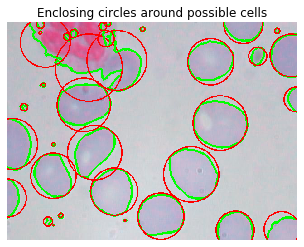

In [17]:
image1_with_contours = image1.copy()
image1_contours = draw_contours_by_edges(image1_with_contours, canny_image1)

Now, let's look at all the steps of the image segmentation but for another image from the dataset.

In [18]:
def find_cell_edges(image, show_steps = True):
    image_with_increased_contrast = increase_contrast(image)
    if show_steps:
        plot_image(image_with_increased_contrast, "Image with increased contrast")
    
    gray_image = cv2.cvtColor(image_with_increased_contrast, cv2.COLOR_RGB2GRAY)
    if show_steps:
        plot_image(gray_image, "Grayscale image")
    
    smoothen_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    if show_steps:
        plot_image(smoothen_image, "Applied Gaussian Blur")
    
    otsu_threshold, otsu_image = cv2.threshold(smoothen_image, 0, 255,
                                               cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    if show_steps:
        plot_image(otsu_image, "Applied Otsu thresholding")
    
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    image_closed_otsu = cv2.morphologyEx(otsu_image, cv2.MORPH_CLOSE, 
                                         structuring_element, iterations = 3)
    if show_steps:
        plot_image(image_closed_otsu, "Applied Closing by 3x3 ellipse")
    
    canny_image = cv2.Canny(image_closed_otsu, otsu_threshold, 0.5*otsu_threshold)
    if show_steps:
        plot_image(canny_image, "Find Canny edges")
    
    return canny_image

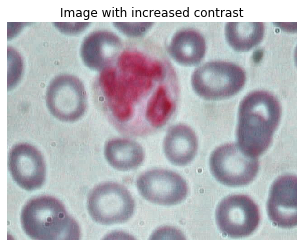

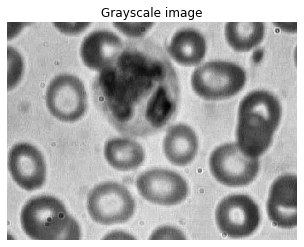

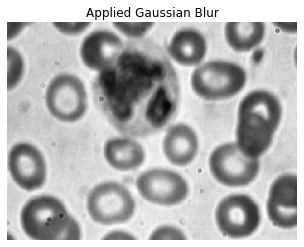

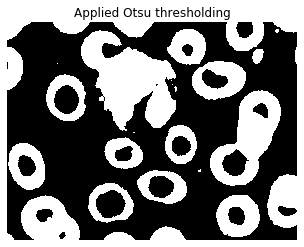

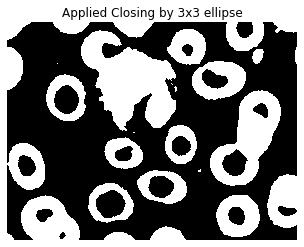

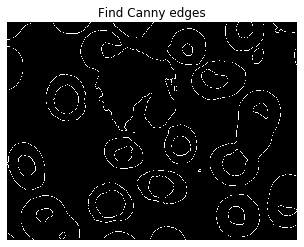

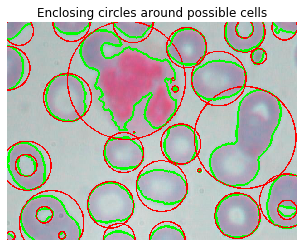

In [19]:
image2_with_defined_edges_around_cells = find_cell_edges(image2)
image2_with_contours = image2.copy()
image2_contours = draw_contours_by_edges(image2_with_contours,
                                         image2_with_defined_edges_around_cells, 
                                         show_figure = False)
plt.show()

As we can see the contours on the edges are not closed, so there is a problem with the object detection there. We cannot just remove the hole of the missing nucleus of RGB as they are not inner contours.

### Extract cell contour features

Actually, now we can extract properties for the cell contours such as hu moments and make a structured dataset. Here is a very basic example.

In [20]:
def write_properites(image_contours, csv_file_name):
    
    output_file = open(csv_file_name, "w")
    output_file.write(",".join(image_contours[0].data.keys()) + "\n")

    for contour in image_contours:
        for value in contour.data.values():
            output_file.write(str(value))
            output_file.write(",")
        output_file.write("\n")


In [21]:
csv_file = os.path.join("data", "contour_features.csv")
write_properites(image1_contours, csv_file)
write_properites(image2_contours, csv_file)

In [22]:
contours_data = pd.read_csv(csv_file, index_col = False)
contours_data = contours_data.drop(["enclosing_circle_center_x", "enclosing_circle_center_y"], axis = 1)
print("Number of all extracted contours from image1 and image2: ", contours_data.shape[0])
contours_data.head()

Number of all extracted contours from image1 and image2:  32


,area,enclosing_circle_diameter,h1,h2,h3,h4,h5,h6,h7
0,8.5,20,2.550015,6.381680,5.716973,5.426326,3.022303e+01,1.348874e+01,1.273375e-01
1,150.0,16,0.169901,0.002835,0.000090,0.000002,-3.070018e-11,-1.160087e-07,7.331658e-13
2,13.0,70,67.609341,4391.670964,1712.658082,518.072661,4.196485e+05,1.371797e+04,-2.490799e+05
3,18.0,78,47.452784,1994.313247,3266.869067,1672.232002,3.677355e+06,4.548917e+04,-1.324188e+06
4,800.0,36,0.172911,0.003088,0.000253,0.000011,2.375884e-10,3.568767e-07,-5.326441e-10


We can see how many possible cell contours are actually similar to circles as we can compare the area of the contour and the area of the min enclosing circle.

In [23]:
circlelike_contours = contours_data[(contours_data.area / pow(contours_data.enclosing_circle_diameter/2, 2)*np.pi) >= 0.95]
print("The number of the circle-like contours: ", circlelike_contours.shape[0])

The number of the circle-like contours:  17


## Visual tests with another different dataset

Now, let's try with some different dataset and see whether the segmentation is at least a little bit robust and can extract cells from other images.
The other dataset is actually an online atlas - Hematology Atlas with a few images of blood smears in case of leukemias. 

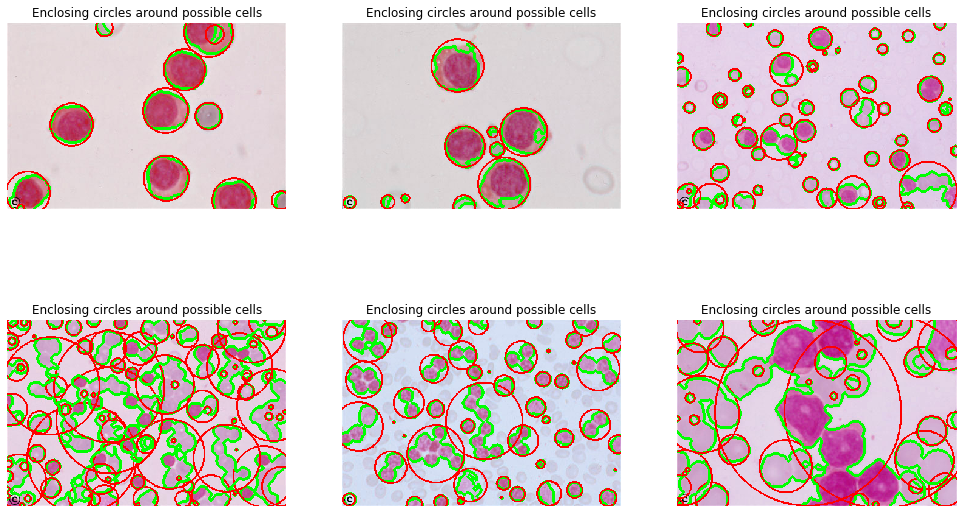

In [24]:
URL2 = "http://www.hematologyatlas.com/leukemias/"
_, axes_tuples = plt.subplots(2, 3, figsize = (17, 10))
axes = [ax for t in axes_tuples for ax in t] 
a = 45
b = a + len(axes)+1
for i in range(a, b):
    test_image = read_image_by_url(URL2 + str(i) + ".jpg")
    #plot_image(test_image, "Test Blood Smear Image " + str(i), 
    #           plot_axis = axes[i-1], show_figure = False)
    test_image_edges = find_cell_edges(test_image, show_steps = False)
    image_contours = draw_contours_by_edges(test_image, test_image_edges,
                                            plot_axis = axes[i-a-1],
                                            show_figure = False)
plt.show()  

Unfortunately, as in the base dataset, it can be clearly seen that the image segmentation technique should still be further improved in order to extract more correctly tightly connected cells as it consider them as one whole blob. Here it is even more clear with different dimensions of the blood smear and more white blood cells that vary more in shapes.

## Conclusion

Image segmentation and cells features extraction is important process toward further investigation of properties of cells and creating machine learning models. In this notebook, we look through some of the very basic steps for extracting of cells and their feautures from different images with blood smears.

## Bibliography

1. OpenCV tutorials and documentation: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html

2. Abdullah Elen, Muhammed Kamil Turan, A new approach for fully automated segmentation of peripheral blood smears, https://www.academia.edu/35289070/A_new_approach_for_fully_automated_segmentation_of_peripheral_blood_smears?email_work_card=reading-history

3. Classification of Leukemia Detection in Human Blood Sample Based on Microscopic Images,  Ei Ei Chaw, Ohnmar Win https://www.academia.edu/resource/work/39747420/Classification_of_Leukemia_Detection_in_Human_Blood_Sample_Based_on_Microscopic_Images?email_work_card=reading-history

4. Sreenivas Bhattiprolu, Python for Microscopists: https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

5. Image and video processing: From Mars to Hollywood with a stop at the hospital, Guillermo Sapiro of Duke university
https://www.youtube.com/watch?v=bxhJEe38bhY&list=PLZ9qNFMHZ-A79y1StvUUqgyL-O0fZh2rs

6. Computer Vision, Algorithms and Applications, Richard Szeliski - https://link.springer.com/book/10.1007/978-1-84882-935-0

7. https://theailearner.com/image-processing/